# Bike Sharing Demand Prediction

Bike sharing has become very popular in major cities as an alternative transportation mode. Bike rental and return is administered through automated kiosk locations all aroud the city.

## Goal of the Project

The goal of the project is to predict the demand of the bikes in a given day and hour. Root mean square logarithmic error (RMSLE) will be utilized for evaluation. RMSLE logs each RMSE and penalizes underestimated error more than overestimated errors.

## Data 

Following are the features and their descriptions:

- datetime
- season. 1 = spring, 2 = summer, 3 = fall, 4 = winter
holiday. whether the day is a holiday or not
- workingday. whether the day is neither a weekend nor holiday
weather.
- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals (Dependent Variable)

## Import Necessary package libraries

In [110]:
import pylab
import calendar
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import missingno as msno
from datetime import datetime as dt
import matplotlib.pyplot as plt
import warnings
pd.options.mode.chained_assignment = None

#import the necessary modelling algos.

#classifiaction.
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC,SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

#regression
from sklearn.linear_model import LinearRegression,Ridge,Lasso,RidgeCV
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

#model selection
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

#evaluation metrics
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error # for regression
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score  # for classification
 

warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

## Read the Data

In [73]:
data = pd.read_csv("train.csv")
data.shape

(10886, 12)

In [74]:
data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [75]:
data.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

## Feature Engineering
Based on the data types, we will do the following:
- Create new features from datetime: date, hour, dayofweek, month, and drop datetime.
- Change season, holiday, workingday, and weather to categorical data type. 

In [76]:
# Converting to datetime first.
data.datetime = pd.to_datetime(data.datetime)
data['year'] = data['datetime'].dt.year
data['month'] = data['datetime'].dt.month
data['day'] = data['datetime'].dt.day
data['hour'] = data['datetime'].dt.hour
data['dayofweek'] = data['datetime'].dt.week

data['season'] = data.season.map({1: 'Spring', 2 : 'Summer', 3 : 'Fall', 4 :'Winter' })
data['weather'] = data.weather.map({1: ' Clear + Few clouds + Partly cloudy + Partly cloudy', 2 : ' Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist ', 3 : ' Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds', 4 :' Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog ' })

# Changing type to categorical
categorical_list = ['year', 'month', 'day', 'hour', 'dayofweek', 'season', 'weather', 'holiday', 'workingday'] 

for var in categorical_list :
    data[var] = data[var].astype('category')
    
# Drop datetime
data  = data.drop(['datetime'],axis=1)

### Let's check for missing values
No missing values in the data

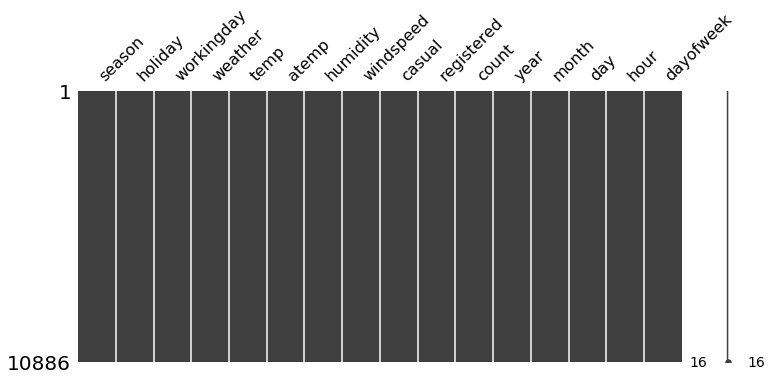

In [77]:
msno.matrix(data,figsize=(12,5))

### Let's check for outliers
- Count has a lot of outliers.
- Spring has less counts.
- Commuter times have higher median value (7 to 8 AM and 5 to 6 PM)
- There are more outliers in working days

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Working Day'),
 Text(0.5, 1.0, 'Box Plot On Count Across Working Day')]

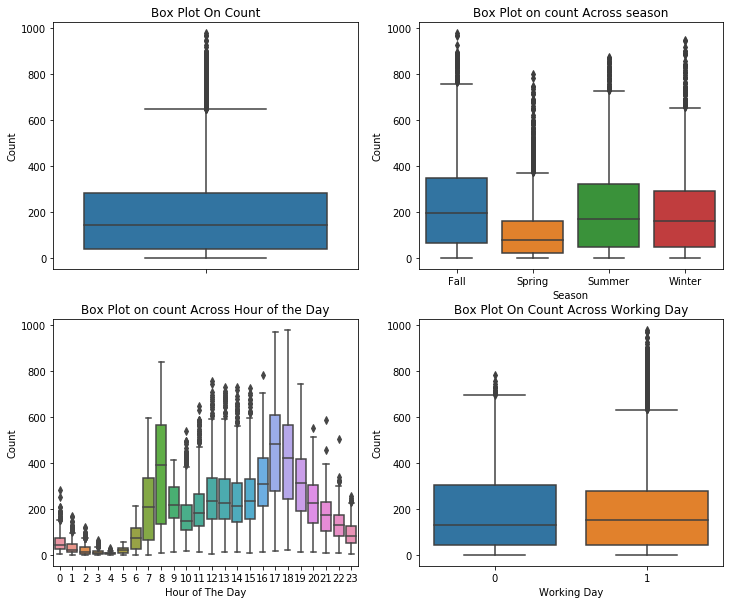

In [78]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)
sn.boxplot(data=data, y='count', orient='v', ax=axes[0][0])
sn.boxplot(data=data, y='count', x='season', orient='v', ax=axes[0][1])
sn.boxplot(data=data, y='count', x='hour', orient='v', ax=axes[1][0])
sn.boxplot(data=data, y='count', x='workingday', orient='v', ax=axes[1][1])

axes[0][0].set(ylabel='Count',title='Box Plot On Count')
axes[0][1].set(xlabel='Season', ylabel='Count',title='Box Plot on count Across season')
axes[1][0].set(xlabel='Hour of The Day', ylabel='Count',title='Box Plot on count Across Hour of the Day')
axes[1][1].set(xlabel='Working Day', ylabel='Count',title='Box Plot On Count Across Working Day')

### Let's remove the outliers

In [79]:
data_cleaned = data[np.abs(data['count']-data['count'].mean())<=(3*data['count'].std())] 
print('Shape with Outliers: ', data.shape)
print('Shape without Outliers: ', data_cleaned.shape)
print('Outliers Removed: ', data.shape[0] - data_cleaned.shape[0])

Shape with Outliers:  (10886, 16)
Shape without Outliers:  (10739, 16)
Outliers Removed:  147


## Correlation Analysis
- temp and atemp are strongly correlated and one of the will be dropped.
- casual, registered, and windspeed may not be useful.

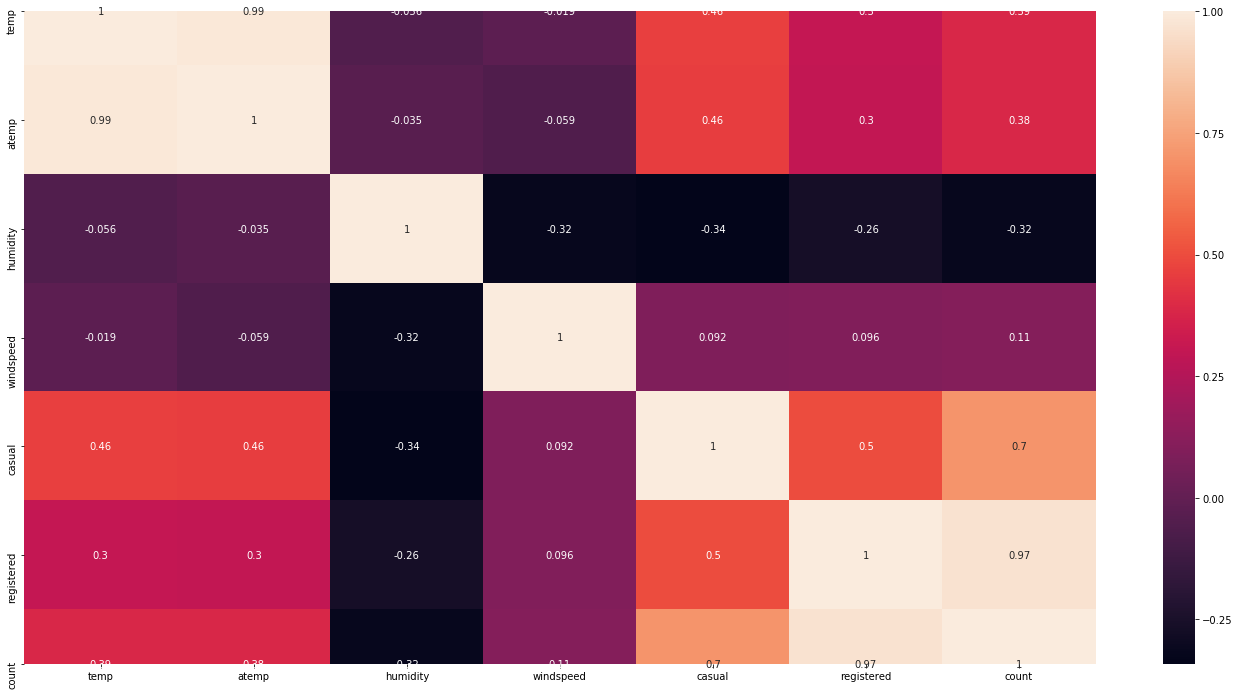

In [80]:
plt.figure(figsize=(24,12))
sns.heatmap(data_cleaned.corr(), annot=True)
plt.show()

In [120]:
data_cleaned.corr()

,temp,atemp,humidity,windspeed,casual,registered,count
temp,1.000000,0.985254,-0.056394,-0.019460,0.460774,0.304328,0.385954
atemp,0.985254,1.000000,-0.035467,-0.059403,0.456319,0.301074,0.381967
humidity,-0.056394,-0.035467,1.000000,-0.320158,-0.341204,-0.263525,-0.317028
windspeed,-0.019460,-0.059403,-0.320158,1.000000,0.092334,0.096104,0.106074
casual,0.460774,0.456319,-0.341204,0.092334,1.000000,0.498085,0.704764
registered,0.304328,0.301074,-0.263525,0.096104,0.498085,1.000000,0.966209
count,0.385954,0.381967,-0.317028,0.106074,0.704764,0.966209,1.000000


Let's have a closer look at the relationship between count vs. temp, humidity, and windspeed.

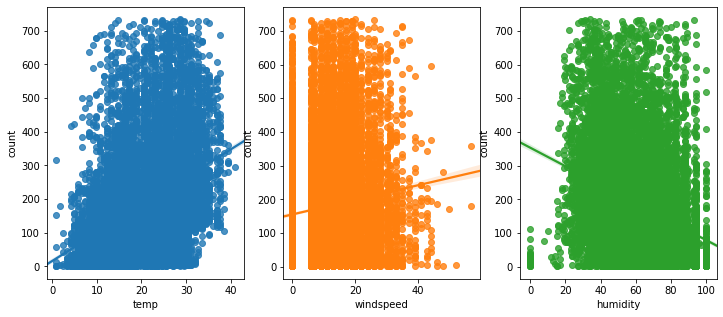

In [81]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12, 5)
sn.regplot(x='temp', y='count', data=data_cleaned, ax=ax1)
sn.regplot(x='windspeed', y='count', data=data_cleaned, ax=ax2)
sn.regplot(x='humidity', y='count', data=data_cleaned, ax=ax3)

### Data Distribution

- It looks like the data is skewed to the right, which might effect some of the machine learning algorithms. 
- Data is transformed through log transformation. Although it is still not exaclty normally distributed, it looks much better than before.

((array([-3.82819677, -3.60401975, -3.48099008, ...,  3.48099008,
          3.60401975,  3.82819677]),
  array([0.69314718, 0.69314718, 0.69314718, ..., 6.5971457 , 6.59850903,
         6.5998705 ])),
 (1.3486990121229776, 4.562423868087808, 0.9581176780909617))

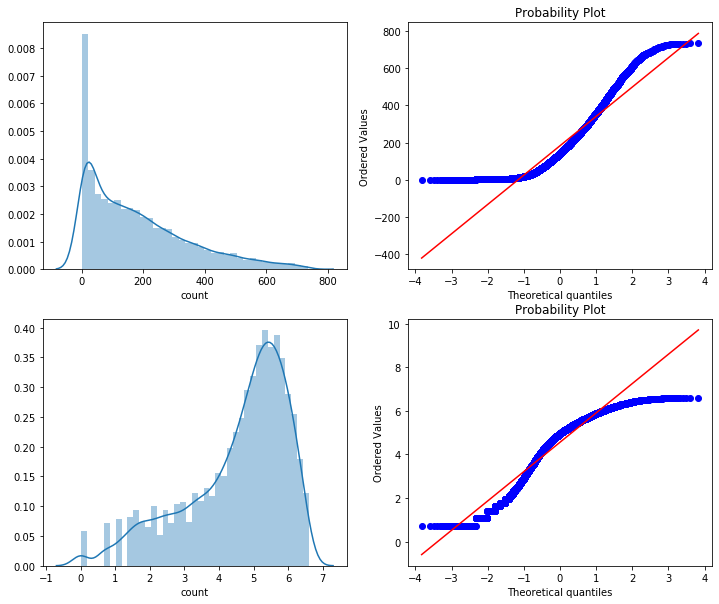

In [82]:
fig,axes = plt.subplots(ncols=2,nrows=2)
fig.set_size_inches(12, 10)
sn.distplot(data_cleaned['count'],ax=axes[0][0])
stats.probplot(data_cleaned['count'], dist='norm', fit=True, plot=axes[0][1])
sn.distplot(np.log(data_cleaned['count']),ax=axes[1][0])
stats.probplot(np.log1p(data_cleaned['count']), dist='norm', fit=True, plot=axes[1][1])

In [106]:
final_df=data_cleaned.drop(['temp','windspeed','casual','registered'], axis=1)
final_df.head()

,season,holiday,workingday,weather,atemp,humidity,count,year,month,day,hour,dayofweek
0,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly c...,14.395,81,16,2011,1,1,0,52
1,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly c...,13.635,80,40,2011,1,1,1,52
2,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly c...,13.635,80,32,2011,1,1,2,52
3,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly c...,14.395,75,13,2011,1,1,3,52
4,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly c...,14.395,75,1,2011,1,1,4,52


### Adding dummy varibles to categorical data

In [107]:
weather_df = pd.get_dummies(data_cleaned['weather'],prefix='w',drop_first=True)
year_df=pd.get_dummies(data_cleaned['year'],prefix='y',drop_first=True)
month_df = pd.get_dummies(data_cleaned['month'],prefix='m',drop_first=True)
hour_df = pd.get_dummies(data_cleaned['hour'],prefix='h',drop_first=True)
season_df = pd.get_dummies(data_cleaned['season'],prefix='s',drop_first=True)
                     
final_df=final_df.join(weather_df)
final_df=final_df.join(year_df)
final_df=final_df.join(month_df)                     
final_df=final_df.join(hour_df)
final_df=final_df.join(season_df)

final_df = final_df.drop(['season','weather','year','month', 'hour'], axis=1)
final_df.head()

,holiday,workingday,atemp,humidity,count,day,dayofweek,"w_ Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog","w_ Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds","w_ Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist",...,h_17,h_18,h_19,h_20,h_21,h_22,h_23,s_Spring,s_Summer,s_Winter
0,0,0,14.395,81,16,1,52,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,13.635,80,40,1,52,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,13.635,80,32,1,52,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,14.395,75,13,1,52,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,14.395,75,1,1,52,0,0,0,...,0,0,0,0,0,0,0,1,0,0


# Modeling Development
Now that our features are finalized we can move to modeling. First, we will split the data and then we use several algorithms to predict based on the test data. Then, we tune a bit to try to get better result.

In [109]:
from sklearn.model_selection import train_test_split,cross_validate

x_train,x_test,y_train,y_test=train_test_split(final_df.drop('count',axis=1),final_df['count'],test_size=0.25,random_state=42)

In [111]:
models=[RandomForestRegressor(),AdaBoostRegressor(),BaggingRegressor(),SVR(),KNeighborsRegressor()]
model_names=['RandomForestRegressor','AdaBoostRegressor','BaggingRegressor','SVR','KNeighborsRegressor']
rmsle=[]
d={}
for model in range (len(models)):
    clf=models[model]
    clf.fit(x_train,y_train)
    test_pred=clf.predict(x_test)
    rmsle.append(np.sqrt(mean_squared_log_error(test_pred,y_test)))
d={'Modelling Algo':model_names,'RMSLE':rmsle}   
d

{'Modelling Algo': ['RandomForestRegressor',
  'AdaBoostRegressor',
  'BaggingRegressor',
  'SVR',
  'KNeighborsRegressor'],
 'RMSLE': [0.5137008954009522,
  1.4609233959312813,
  0.5241071485903028,
  1.2732518642391515,
  1.2236072916356135]}

In [112]:
rmsle_frame=pd.DataFrame(d)
rmsle_frame

,Modelling Algo,RMSLE
0,RandomForestRegressor,0.513701
1,AdaBoostRegressor,1.460923
2,BaggingRegressor,0.524107
3,SVR,1.273252
4,KNeighborsRegressor,1.223607


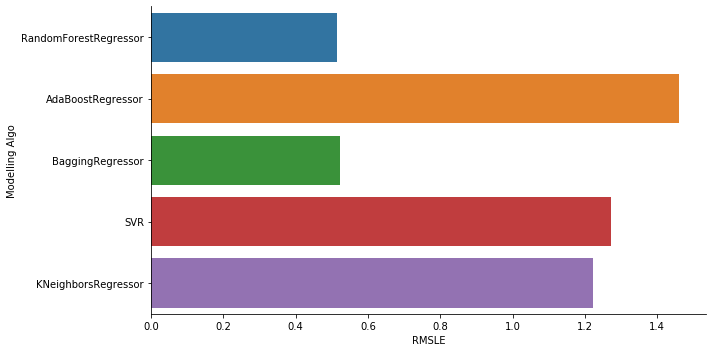

In [114]:
sns.factorplot(y='Modelling Algo',x='RMSLE',data=rmsle_frame,kind='bar',size=5,aspect=2)

In [115]:
#for random forest regresion.
no_of_test=[500]
params_dict={'n_estimators':no_of_test,'n_jobs':[-1],'max_features':["auto",'sqrt','log2']}
clf_rf=GridSearchCV(estimator=RandomForestRegressor(),param_grid=params_dict,scoring='neg_mean_squared_log_error')
clf_rf.fit(x_train,y_train)
pred=clf_rf.predict(x_test)
print((np.sqrt(mean_squared_log_error(pred,y_test))))

0.5071140366800297


In [117]:
clf_rf.best_params_

{'max_features': 'auto', 'n_estimators': 500, 'n_jobs': -1}

In [118]:
# for KNN
n_neighbors=[]
for i in range (0,50,5):
    if(i!=0):
        n_neighbors.append(i)
params_dict={'n_neighbors':n_neighbors,'n_jobs':[-1]}
clf_knn=GridSearchCV(estimator=KNeighborsRegressor(),param_grid=params_dict,scoring='neg_mean_squared_log_error')
clf_knn.fit(x_train,y_train)
pred=clf_knn.predict(x_test)
print((np.sqrt(mean_squared_log_error(pred,y_test))))

1.2236072916356135


In [119]:
clf_knn.best_params_

{'n_jobs': -1, 'n_neighbors': 5}